# [How to apply LSTM using PyTorch](https://cnvrg.io/pytorch-lstm/) - Practical Implementation in PyTorch


In [1]:
import sys
import os
from os import path
import importlib

import numpy as np
np.set_printoptions(formatter={'float_kind':"{:-.3e}".format})
np.random.seed(0)

import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 4)

import torch
torch.manual_seed(0)

import torch.nn as nn
from torch.autograd import Variable

SRC_DIR = path.join(os.path.abspath(""), '../')
sys.path.append(SRC_DIR)

import core as co
from core import _
import hist_data as hd

In [281]:
hd.set_hist_data(data_count=None)

In [ ]:
# def sinus_data(num):
#     return np.sin([i * .1 for i in range(num)])

# def sinus_data_source(index=None, total_len=None, debug=False):
#     if index is None:
#         return None
#     _data = sinus_data(total_len)
#     data_X = []
#     data_y = []
#     for i in range(0, total_len):
#         y = _data[i]
#         if debug:
#             y = i
#         data_y.append(y)
#         # data_X.append((y, hd_values[i][2]))
#         data_X.append(y)

#     return data_X, data_y

In [5]:
import nn_tools.data_sequencer as ds

start_day = 0
context_len = 10
future_len = 5

cs = ds.ContextSequencer(
    ds.ForexDataSource, start_day=start_day, seq_len=context_len, 
    future_len=future_len)

X_train, y_train = cs.get_sequences(num=1000)
X_test, y_test = cs.get_sequences(num=50)


In [4]:
deb = ds.ContextSequencer(ds.ForexDataSource, start_day=0, seq_len=3, future_len=2)
deb.get_sequences(num=3, debug=True)
deb.get_sequences(num=3, debug=True)

start=8 data len=8, seq_len=3, num=3 future_len=2
x:
[[0 1 2]
 [1 2 3]
 [2 3 4]]
y:
[4 5 6]
start=16 data len=8, seq_len=3, num=3 future_len=2
x:
[[ 8  9 10]
 [ 9 10 11]
 [10 11 12]]
y:
[12 13 14]


(array([[ 8,  9, 10],
        [ 9, 10, 11],
        [10, 11, 12]]),
 array([12, 13, 14]))

In [6]:
# future = 1
# X_train, y_train, X_test, y_test = train_test_data(
#     sinus_data_source, 
#     training=1000, 
#     testing=50, 
#     seq_len=10,
#     future=future)

# _("""``Orange y_train[0]`` is next to the blue sequence ``X_train[0]``. Blue balls are
# single input to LSTM nn, orange one is the learning pattern.
# """)
# yy = X_train[0]
# xx = [_ for _ in range(len(yy))]
# plt.scatter(xx, yy, color='blue', label='X_train[0]')
# plt.scatter([len(yy) + future], y_train[0], color='orange', label='y_train[0]', 
#             linewidths=10, alpha=0.5)
# plt.legend()
# plt.show()

In [25]:
def data_preprocessing(X, y):
    X = StandardScaler().fit_transform(X)
    X = Variable(torch.Tensor(X))
    X = torch.reshape(X, (X.shape[0], 1, X.shape[1]))

    y = y.reshape(-1, 1)
    y = MinMaxScaler().fit_transform(y)
    y = Variable(torch.Tensor(y))

    # X = torch.tensor(X[:, :, None], dtype=torch.float32)
    # y = torch.tensor(y[:, None], dtype=torch.float32)

    return X, y



def nn_trening_result(model, X, y, offset=0, label='', color='blue', alpha=1, verbose=None):
    X, y = data_preprocessing(X, y)
    
    (mm := MinMaxScaler()).fit_transform(y) # 'Close' column
    y = mm.transform(y) #old transformers
    y = Variable(torch.Tensor(y))    #reshaping the dataset

    y_np = y.data.numpy()
    y_np = np.transpose(mm.inverse_transform(y_np))

    nn_answer = model(X)#forward pass

    if verbose is not None:
        print(f'''
              {verbose}
formatted feature data (length is {len(X)}): 
    {X[:1]}

NN question[:1] (converted from formatted feature data, length is {len(X)}):
    {X[:1]}
NN answer[:5] (length is {len(nn_answer)}): 
    {nn_answer[:1]}
              ''')

    data_predict = nn_answer.data.numpy() #numpy conversion
    data_predict = mm.inverse_transform(data_predict) #reverse transformation
    time = np.array([_ for _ in range(offset, offset + len(X))])

    data_predict = np.transpose(data_predict)
    for i in range(len(data_predict)):
        diff_0 = y_np[i][1] - data_predict[i][0]
        y_np[i] = y_np[i] - diff_0

        plt.plot((time - 1)[130:], y_np[i][130:], label=label + f'- Actual Data', color='black', 
                 alpha=0.2, linewidth=5) #actual plot
        plt.plot(time[130:], data_predict[i][130:], label=label + f'- Predicted Data', 
                 color=color, alpha=alpha) #predicted plot
        plt.legend()
        plt.show() 

In [8]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(Model, self).__init__()

        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.model = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size,
            num_layers=num_layers, 
            batch_first=True)
        
        self.fc =  nn.Linear(hidden_size, output_size)

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        out, (h_n, c_n) = self.model(x, (h_0.detach(), c_0.detach()))
        out = self.fc(out[:, -1, :])  # Selecting the last output

        return out

In [9]:
num_epochs = 1000
accuracy = 1e-5
learning_rate = 0.001

input_size = 10
hidden_size = 100
output_size = 1
num_layers = 3

In [10]:
X_train_t, y_train_t = data_preprocessing(X_train, y_train)

model = Model(input_size, hidden_size, num_layers, output_size)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [11]:
loss0 = None
for epoch in range(num_epochs):
    outputs = model(X_train_t)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_t)  
    loss.backward()
    if loss0 is None:
        loss0 = loss.item()
    if loss.item() / loss0 < accuracy:
        break
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.1e}')

Epoch [10/1000], Loss: 3.2e-01
Epoch [20/1000], Loss: 1.7e-01
Epoch [30/1000], Loss: 3.1e-02
Epoch [40/1000], Loss: 7.4e-03
Epoch [50/1000], Loss: 8.6e-03
Epoch [60/1000], Loss: 6.0e-03
Epoch [70/1000], Loss: 3.9e-03
Epoch [80/1000], Loss: 3.3e-03
Epoch [90/1000], Loss: 2.9e-03
Epoch [100/1000], Loss: 2.5e-03
Epoch [110/1000], Loss: 2.2e-03
Epoch [120/1000], Loss: 2.0e-03
Epoch [130/1000], Loss: 1.8e-03
Epoch [140/1000], Loss: 1.7e-03
Epoch [150/1000], Loss: 1.7e-03
Epoch [160/1000], Loss: 1.6e-03
Epoch [170/1000], Loss: 1.6e-03
Epoch [180/1000], Loss: 1.6e-03
Epoch [190/1000], Loss: 1.6e-03
Epoch [200/1000], Loss: 1.6e-03
Epoch [210/1000], Loss: 1.6e-03
Epoch [220/1000], Loss: 1.6e-03
Epoch [230/1000], Loss: 1.6e-03
Epoch [240/1000], Loss: 1.6e-03
Epoch [250/1000], Loss: 1.6e-03
Epoch [260/1000], Loss: 1.5e-03
Epoch [270/1000], Loss: 1.5e-03
Epoch [280/1000], Loss: 1.5e-03
Epoch [290/1000], Loss: 1.5e-03
Epoch [300/1000], Loss: 1.5e-03
Epoch [310/1000], Loss: 1.5e-03
Epoch [320/1000],


              
formatted feature data (length is 50): 
    tensor([[[-0.9112, -0.2479, -0.3334, -1.4693, -2.0194, -1.5133, -2.0235,
          -2.0714, -1.1654, -1.5828]]])

NN question[:1] (converted from formatted feature data, length is 50):
    tensor([[[-0.9112, -0.2479, -0.3334, -1.4693, -2.0194, -1.5133, -2.0235,
          -2.0714, -1.1654, -1.5828]]])
NN answer[:5] (length is 50): 
    tensor([[0.1038]], grad_fn=<SliceBackward0>)
              


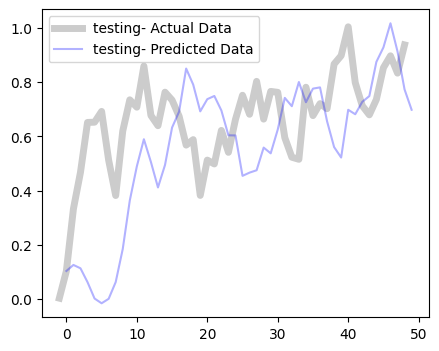

In [12]:
nn_trening_result(model, X_test, y_test,
        offset=0, label='testing', color='blue', alpha=0.3, verbose='')

In [13]:
print(model)

Model(
  (model): LSTM(10, 100, num_layers=3, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)



              
formatted feature data (length is 135): 
    tensor([[[-0.5964, -0.7095, -0.6643, -1.2067, -1.0081, -0.9367, -0.9969,
          -0.9011, -0.9353, -1.0610]]])

NN question[:1] (converted from formatted feature data, length is 135):
    tensor([[[-0.5964, -0.7095, -0.6643, -1.2067, -1.0081, -0.9367, -0.9969,
          -0.9011, -0.9353, -1.0610]]])
NN answer[:5] (length is 135): 
    tensor([[0.2543]], grad_fn=<SliceBackward0>)
              


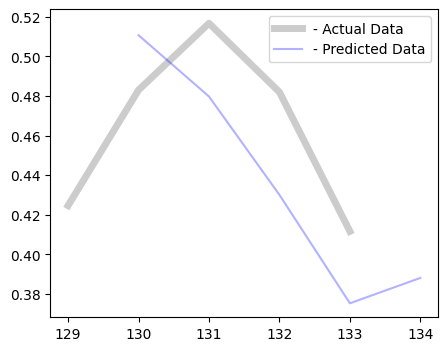

In [27]:
X, y = cs.get_sequences(num=135)
nn_trening_result(model, X, y,
offset=0, label='', color='blue', alpha=0.3, verbose='')